In [1]:
import ipywidgets
import umap.umap_ as umap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, adjusted_rand_score
import seaborn as sns
import os
from ipywidgets import interact
from matplotlib.widgets import Slider
from umap import UMAP

# Part 1: Supervised Learning
## 1a. Data Loading and Cleaning

In [344]:
# load from subfolder relative to current directory and drop missing

trainX = pd.read_csv('train.csv')
testX = pd.read_csv('test.csv')
trainY = pd.read_csv('train_short_labels.csv')
testY = pd.read_csv('test_short_labels.csv')
blindX = pd.read_csv('blind_test.csv')

print("Any values missing from training: " + str(trainX.isnull().any().any()))
print("Any values missing from testing: " + str(testX.isnull().any().any()))
print("Any values missing from training labels: " + str(trainY.isnull().any().any()))
print("Any values missing from testing labels: " + str(testY.isnull().any().any()))
print("Any values missing from blind: " + str(blindX.isnull().any().any()))

# versions of the dataframes without missing values. In other situations we want to keep the existence of the rows in order to do the 
# movmean properly, or else delete the whole chunk (unnecessary)
trainX_nn = trainX.dropna()
testX_nn = testX.dropna()
trainY_nn = trainY.dropna()
testY_nn = testY.dropna()
blindX_nn = blindX.dropna()
    
# get regular matrix copies because i'm a neanderthal 
trainX_m = trainX_nn.to_numpy()
testX_m = testX_nn.to_numpy()
trainY_m = trainY_nn.to_numpy()
testY_m = testY_nn.to_numpy()
blindX_m = blindX_nn.to_numpy()

# 150 row chunks

Any values missing from training: False
Any values missing from testing: False
Any values missing from training labels: False
Any values missing from testing labels: False
Any values missing from blind: False


## 1b. Calculating Area

In [394]:
# Area as a measure of outlier-ness and as a feature

import scipy.spatial
from scipy.spatial import ConvexHull

def getAreas(matrix):
    area = np.zeros((len(matrix), 2))

    for i in range(0,len(matrix)):
        temp = np.hsplit(matrix[i,1:27], 2)
        temp = np.transpose(temp)
        area[i, 0] = ConvexHull(temp).area

        temp = np.hsplit(matrix[i,27:53], 2)
        temp = np.transpose(temp)
        area[i, 1] = ConvexHull(temp).area

    return area

trainX_area = getAreas(trainX_m)
testX_area = getAreas(testX_m)
blindX_area = getAreas(blindX_m)

## 1c. Identifying and Printing Out Outliers

In [415]:
# calculate and print out outliers using area
# from https://www.askpython.com/python/examples/how-to-determine-outliers

q1 = np.percentile(trainX_area, 25)
q3 = np.percentile(trainX_area, 75)
iqr = q3 - q1
threshold = 1.5 * iqr
outliers = np.where((trainX_area < q1 - threshold) | (trainX_area > q3 + threshold))
 
print("Outliers of trainX is : \n", trainX_area[outliers], "\nThis is " + str(outliers[0].size/trainX_area.size) + "% of the data")

Outliers of trainX is : 
 [359.70591601 345.67124445 351.55053588 ... 349.55037438 353.96891413
 342.58978805] 
This is 0.008952083333333333% of the data


In [414]:
q1 = np.percentile(testX_area, 25)
q3 = np.percentile(testX_area, 75)
iqr = q3 - q1
threshold = 1.5 * iqr
outliers = np.where((testX_area < q1 - threshold) | (testX_area > q3 + threshold))
 
print("\n\nOutliers of testX is : \n", testX_area[outliers], "\nThis is " + str(outliers[0].size/testX_area.size) + "% of the data")



Outliers of testX is : 
 [355.90570384 355.4140291  354.32522309 355.64326841 358.18574785
 356.0072955  355.83097042 354.0090924  353.88994872 354.36389604
 357.87144785 356.7957087  381.25735499 379.68394879 378.78518399
 378.90887133 380.88627407 380.74218061 382.01426833 401.4562291
 392.64344686 385.74016424 379.64932108 375.63448758 354.39636532
 354.57417945 355.8576377  354.74617265 355.06585418 354.41648624
 354.69259783 354.11619554 355.80999223 356.54974805 358.73993669
 359.72406283 357.43961568 354.30335304 364.32566569 365.07286325
 358.26190367 400.06826931 372.40877351 456.56439738 511.82672701
 410.35371707 377.12164019 360.53885949 376.63379586 369.19668993
 375.46464681 375.68745057 372.03749606 390.13412497 394.31395676
 361.83869339 364.07713386 410.37299455 373.837019   398.78775951
 392.07884889 403.78966038 390.3801722  376.38468158 357.94745029
 366.49528953 366.62247638 373.94281256 379.18399681 361.65143571
 364.25090936 364.59686773 357.63239214 359.873002

In [413]:
q1 = np.percentile(blindX_area, 25)
q3 = np.percentile(blindX_area, 75)
iqr = q3 - q1
threshold = 1.5 * iqr
outliers = np.where((blindX_area < q1 - threshold) | (blindX_area > q3 + threshold))
 
print("\n\nOutliers of blindX is : \n", blindX_area[outliers], "\nThis is " + str(outliers[0].size/blindX_area.size) + "% of the data")



Outliers of blindX is : 
 [382.70756273 367.12236976 367.98074213 ... 367.09622159 367.99819245
 366.78881387] 
This is 0.007679166666666667% of the data


## 1d. Comparing Male/Female Area Distribution & Investigating Reasons for Outliers

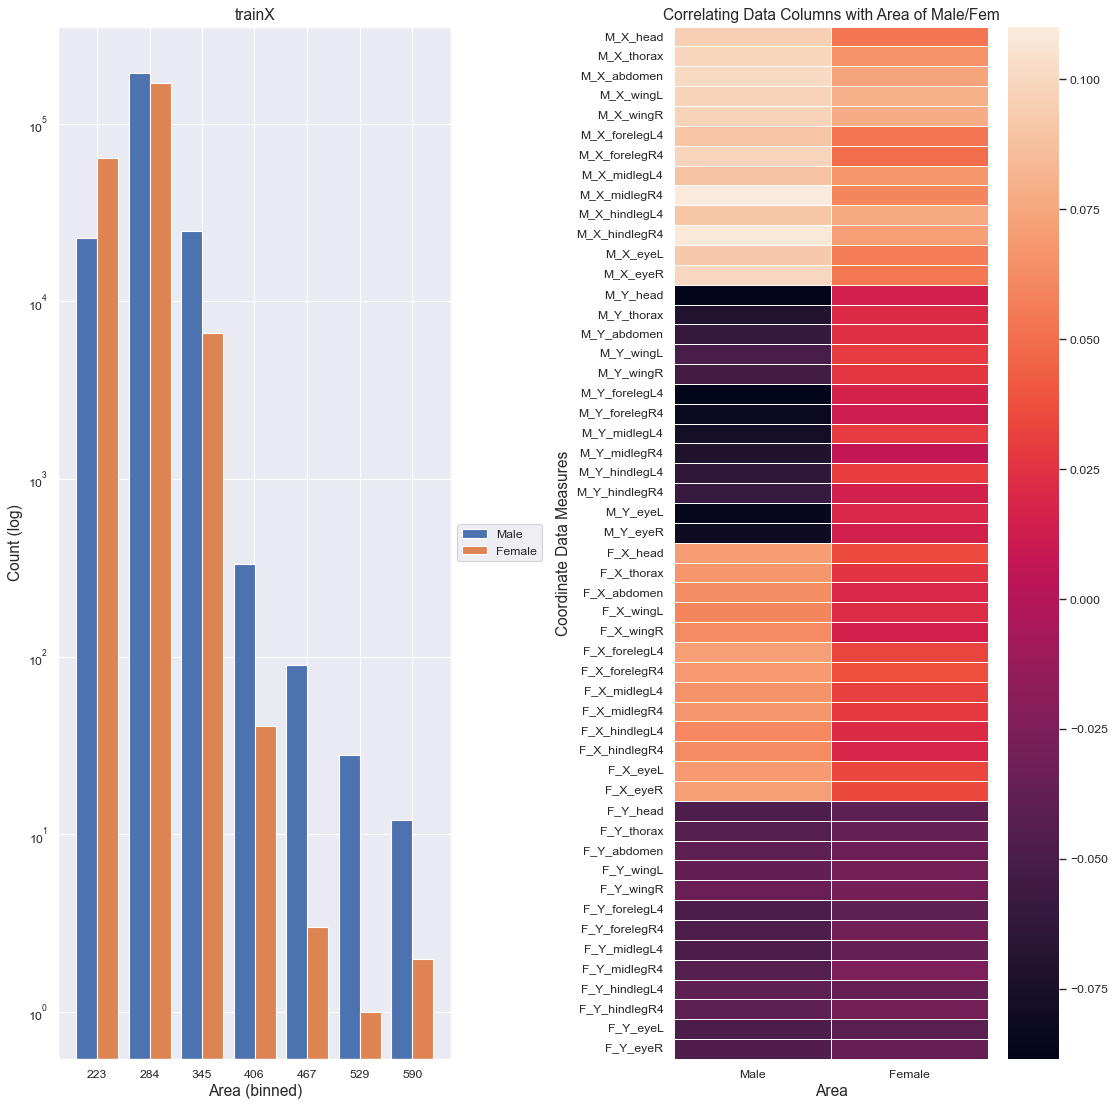

In [441]:
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 14), dpi=80)

sns.set_theme()
_, bins, _  = ax[0].hist(trainX_area, 7, label=["Male", "Female"], log=True)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title("trainX", fontsize=14)
ax[0].set_xlabel("Area (binned)", fontsize=14)
ax[0].set_ylabel("Count (log)", fontsize=14)

xticks = np.zeros([np.size(bins)-1,])
for i in range(0, np.size(xticks)):
    xticks[i] = (bins[i] + bins[i+1]) / 2

ax[0].set_xticks(np.round(xticks))

tx_corr = np.zeros([np.size(trainX_m, 1)-2,2])

for i in [0, 1]:
    for j in range(1, np.size(trainX_m, 1)-1):
        tx_corr[j-1, i] = scipy.stats.spearmanr(trainX_area[:, i], trainX_m[:, j]).statistic

sns.heatmap(tx_corr, ax=ax[1], linewidth=0.5, xticklabels=["Male", "Female"], yticklabels=trainX.columns.values[1:-1])
ax[1].set_title("Correlating Data Columns with Area of Male/Fem", fontsize=14)
ax[1].set_ylabel("Coordinate Data Measures", fontsize=14)
ax[1].set_xlabel("Area", fontsize=14)

fig.tight_layout()

A.  On the left, is the distribution of the area measure for both the male fly and female fly overlapped on another. The data is binned and the y-axis shows the counts of the # of appearences in each bin in log scale. The x-ticks mark the center of each bin.

B. On the right, is the correlation with each measure from SLEAP and the Area for male and female. There is a colorbar on the right, with the color mapped to the scale of the correlation. The columns are according to the two animals in the data, identified by their sex.

This plot aims to demonstrate a few things:
1) The male and female flies have roughly the same size based on the area metric measured here, which is the convex hull of all the points taken in SLEAP. This should not be the case, female flies are supposed to be about 20-30% bigger than male flies in adulthood. I assume these flies are adults or near because the interest in class was around mating behavior. The other confounding variable is that the convex hull takes all points, so the abdomen point is superseded by the wing points => equal area distributions. 

    I don't really know flies well. I would maybe assume that if the flies are bigger than the legs and wings would be bigger too, but I do not know. 

2) Next, I sought to investigate the reason for the outliers. I correlated the area with the coordinates. I saw no significant correlation anywhere. Spikes in area were no associated with any 1 spike in a specific coordinate measure, but it could be due to many at different points. I was expected a spike in area when behavior of a wing being extended in courtship is displayed but that was not seen here in any significance. It could be that in the training data here, that behavior was not captured.

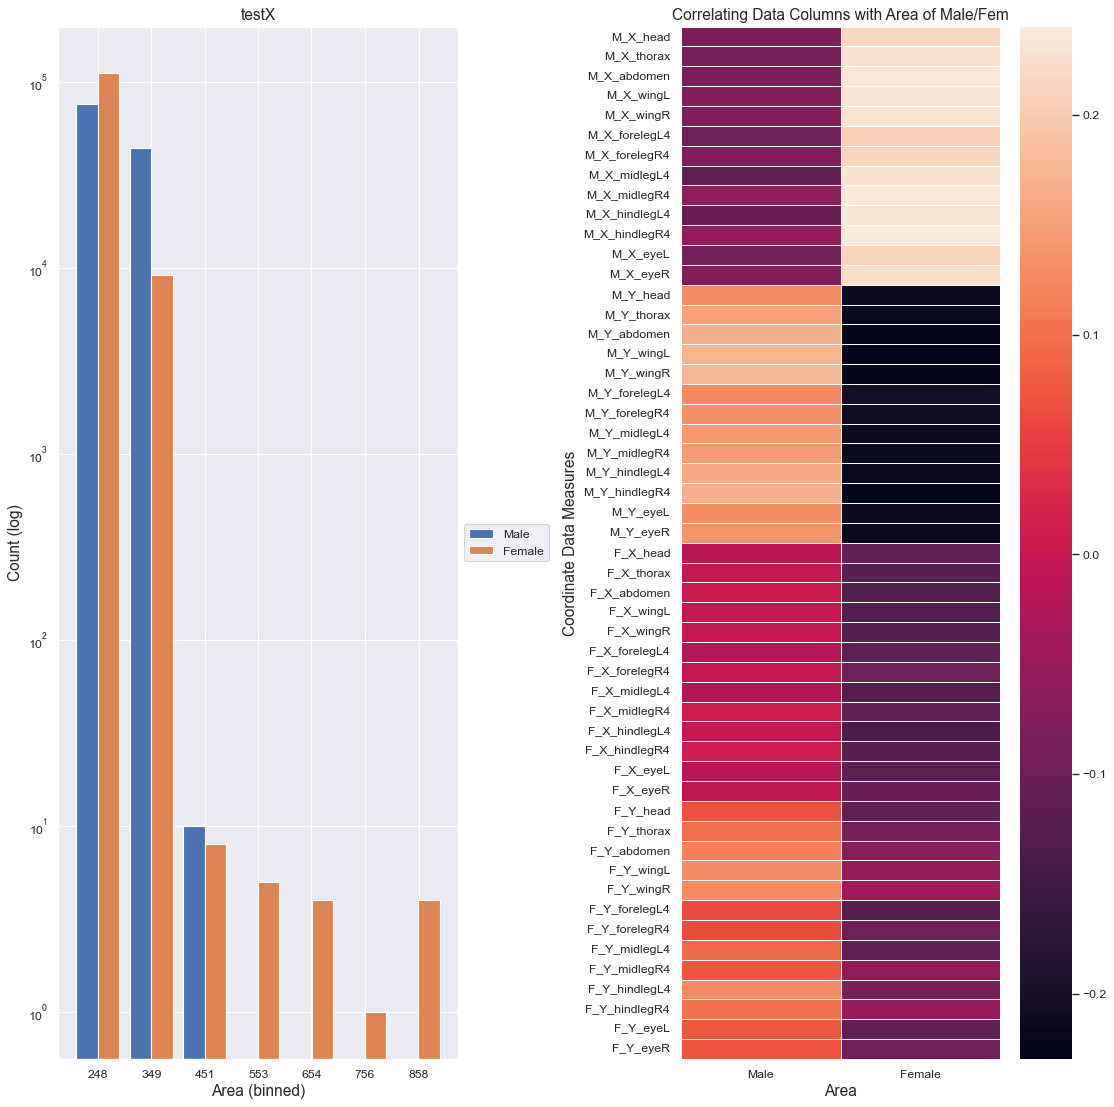

In [440]:
fig, ax = plt.subplots(1, 2, figsize=(14, 14), dpi=80)

sns.set_theme()
_, bins, _ = ax[0].hist(testX_area, 7, label=["Male", "Female"], log=True)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title("testX", fontsize=14)
ax[0].set_xlabel("Area (binned)", fontsize=14)
ax[0].set_ylabel("Count (log)", fontsize=14)

xticks = np.zeros([np.size(bins)-1,])
for i in range(0, np.size(xticks)):
    xticks[i] = (bins[i] + bins[i+1]) / 2

ax[0].set_xticks(np.round(xticks))


tx_corr = np.zeros([np.size(testX_m, 1)-2,2])

for i in [0, 1]:
    for j in range(1, np.size(testX_m, 1)-1):
        tx_corr[j-1, i] = scipy.stats.spearmanr(testX_area[:, i], testX_m[:, j]).statistic

sns.heatmap(tx_corr, ax=ax[1], linewidth=0.5, xticklabels=["Male", "Female"], yticklabels=testX.columns.values[1:-1])
ax[1].set_title("Correlating Data Columns with Area of Male/Fem", fontsize=14)
ax[1].set_ylabel("Coordinate Data Measures", fontsize=14)
ax[1].set_xlabel("Area", fontsize=14)

fig.tight_layout()


A.  On the left, is the distribution of the area measure for both the male fly and female fly overlapped on another. The data is binned and the y-axis shows the counts of the # of appearences in each bin in log scale. The x-ticks mark the center of each bin.

B. On the right, is the correlation with each measure from SLEAP and the Area for male and female. There is a colorbar on the right, with the color mapped to the scale of the correlation. The columns are according to the two animals in the data, identified by their sex.

Just like the training set data, however, there is a difference:
1) We still see an equal distribution in area, but the outliers belong exlusively now to the female fly. The rightmost plot shows some correlation, but nothing significant in terms of a large value that can point me to a reason behind the discrepencies. 

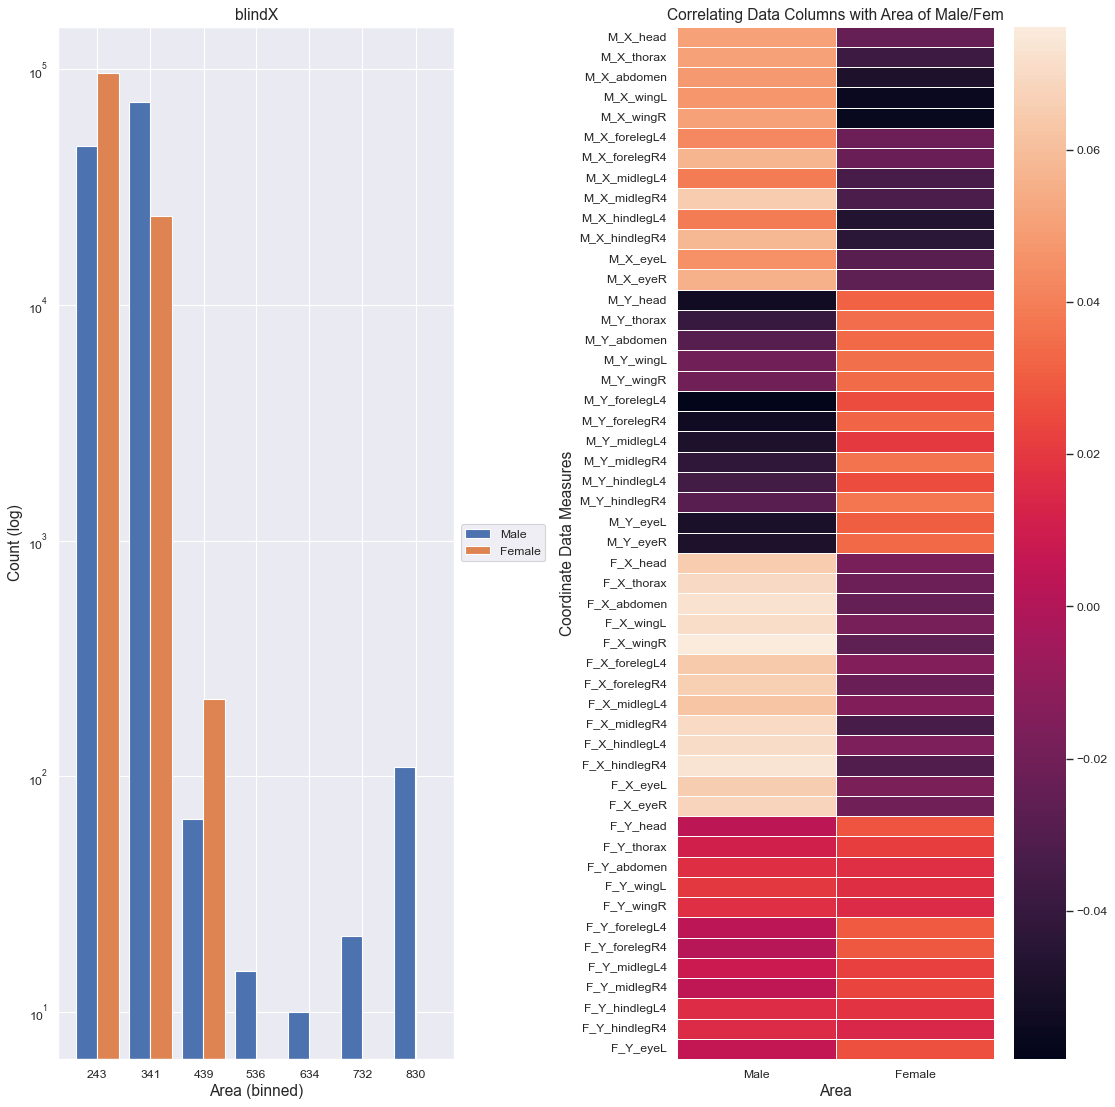

In [439]:
fig, ax = plt.subplots(1, 2, figsize=(14, 14), dpi=80)

sns.set_theme()
_, bins, _ = ax[0].hist(blindX_area, 7, label=["Male", "Female"], log=True)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title("blindX", fontsize=14)
ax[0].set_xlabel("Area (binned)", fontsize=14)
ax[0].set_ylabel("Count (log)", fontsize=14)

xticks = np.zeros([np.size(bins)-1,])
for i in range(0, np.size(xticks)):
    xticks[i] = (bins[i] + bins[i+1]) / 2

ax[0].set_xticks(np.round(xticks))

tx_corr = np.zeros([np.size(blindX_m, 1)-2,2])

for i in [0, 1]:
    for j in range(1, np.size(blindX_m, 1)-1):
        tx_corr[j-1, i] = scipy.stats.spearmanr(blindX_area[:, i], blindX_m[:, j]).statistic

sns.heatmap(tx_corr, ax=ax[1], linewidth=0.5, xticklabels=["Male", "Female"], yticklabels=blindX.columns.values[1:-1])
ax[1].set_title("Correlating Data Columns with Area of Male/Fem", fontsize=14)
ax[1].set_ylabel("Coordinate Data Measures", fontsize=14)
ax[1].set_xlabel("Area", fontsize=14)

fig.tight_layout()


A.  On the left, is the distribution of the area measure for both the male fly and female fly overlapped on another. The data is binned and the y-axis shows the counts of the # of appearences in each bin in log scale. The x-ticks mark the center of each bin.

B. On the right, is the correlation with each measure from SLEAP and the Area for male and female. There is a colorbar on the right, with the color mapped to the scale of the correlation. The columns are according to the two animals in the data, identified by their sex.

Just like the training and test set data, however, again we see a difference:
1) This time, the males are overly represented as an outlier. I do not understand why or how. 

### Conclusion

I would like to combine the coordinates into a single measure and repeat the correlations. I think that would give better, more accurate results, but I do not have the time for this. 

Another, avenue would be removing wings and the endpoints for the legs from the area measure, but this too would be an exercise left for the reader.

# 2. Creating Features

## 2a. Speed (temporal)


In [ ]:
#print(windowSize.value)
from scipy.spatial import distance
import statistics

def getSpeed(matrix):
    numRows = np.size(matrix, 0)
    s50_m = np.zeros([numRows,]) * np.nan
    s25_m = np.zeros([numRows,]) * np.nan
    s15_m = np.zeros([numRows,]) * np.nan

    s50_f = np.zeros([numRows,]) * np.nan
    s25_f = np.zeros([numRows,]) * np.nan
    s15_f = np.zeros([numRows,]) * np.nan

    # for every 150 frame chunk
    for i in range(0, np.size(matrix, 0), 150):
        temp = matrix[i:i+150, :]
        currentChunk = round(i/150)

        # window size 50
        for j in range(0, 101):
            s50_m[(150*currentChunk)+j] = np.linalg.norm(temp[j,[2,15]] - temp[j+49,[2,15]]) / 50
            s50_f[(150*currentChunk)+j] = np.linalg.norm(temp[j,[28,41]] - temp[j+49,[28,41]]) / 50

        # window size 25
        for j in range(0, 126):
            s25_m[(150*currentChunk)+j] = np.linalg.norm(temp[j,[2,15]] - temp[j+24,[2,15]]) / 25
            s25_f[(150*currentChunk)+j] = np.linalg.norm(temp[j,[28,41]] - temp[j+24,[28,41]]) / 25
        
        # window size 15
        for j in range(0, 136):
            s15_m[(150*currentChunk)+j] = np.linalg.norm(temp[j,[2,15]] - temp[j+14,[2,15]]) / 15
            s15_f[(150*currentChunk)+j] = np.linalg.norm(temp[j,[28,41]] - temp[j+14,[28,41]]) / 15

    maleRes = np.column_stack((s50_m, s25_m, s15_m))
    femRes = np.column_stack((s50_f, s25_f, s15_f))
    return(np.column_stack((maleRes, femRes)))


# speed is calculated as the euclidean distance of the thorax in 1 frame to another / (length of the window)
# the window size determines how far you look ahead when calculating the speed
# the function returns values for window sizes of 50, 25 and 15. Later on the user can choose what to insert into the model.

trainSpeed = getSpeed(trainX_m)
testSpeed = getSpeed(testX_m)
blindSpeed = getSpeed(blindX_m)

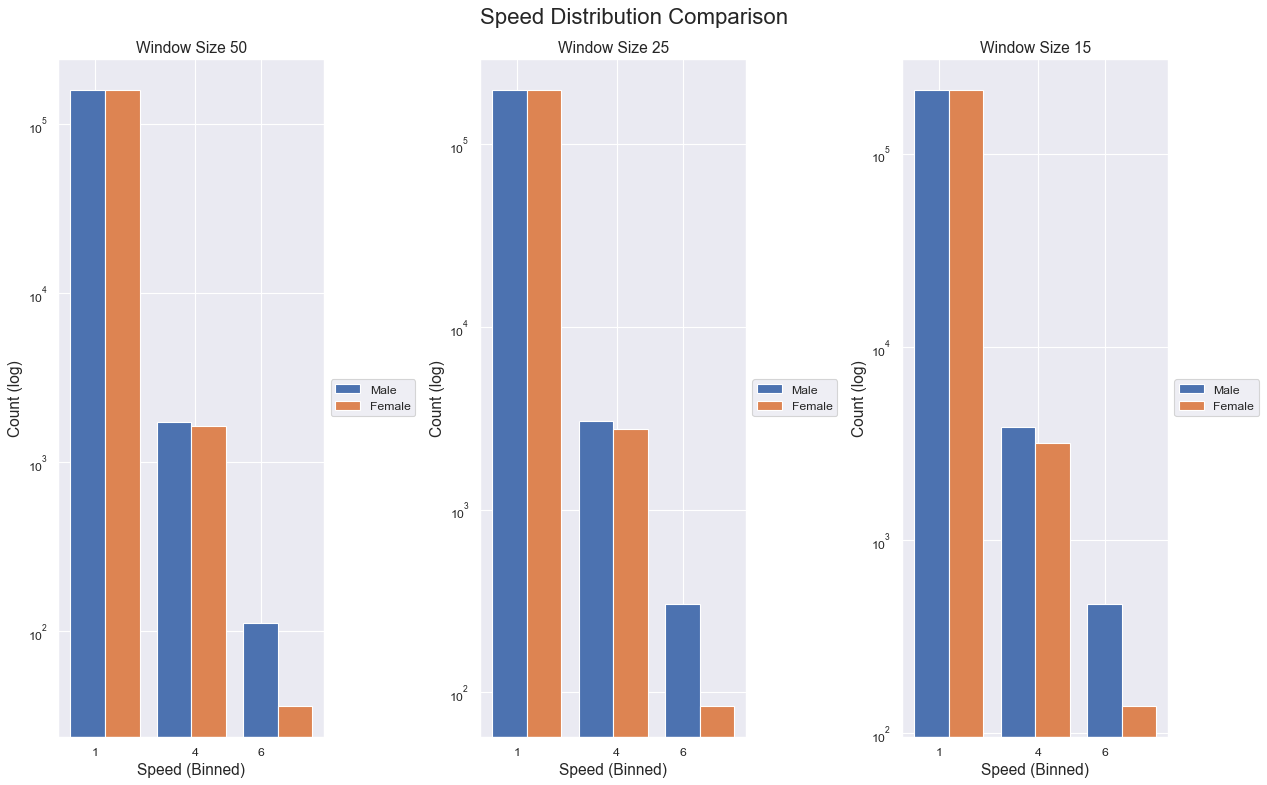

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16,10), dpi=80)
fig.suptitle("Speed Distribution Comparison", fontsize=20)

_, bins, _ = ax[0].hist(trainSpeed[:,[0,3]], 3, label=["Male", "Female"], log=True)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title("Window Size 50", fontsize=14)
ax[0].set_xlabel("Speed (Binned)", fontsize=14)
ax[0].set_ylabel("Count (log)", fontsize=14)

xticks = np.zeros([np.size(bins)-1,])
for i in range(0, np.size(xticks)):
    xticks[i] = (bins[i] + bins[i+1]) / 2

ax[0].set_xticks(np.round(xticks))

_, bins, _ = ax[1].hist(trainSpeed[:,[1,4]], bins, label=["Male", "Female"], log=True)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_title("Window Size 25", fontsize=14)
ax[1].set_xlabel("Speed (Binned)", fontsize=14)
ax[1].set_ylabel("Count (log)", fontsize=14)

#xticks = np.zeros([np.size(bins)-1,])
#for i in range(0, np.size(xticks)):
#    xticks[i] = (bins[i] + bins[i+1]) / 2

ax[1].set_xticks(np.round(xticks))

#plt.subplot(3, 1, 3)
_, bins, _ = ax[2].hist(trainSpeed[:,[2,5]], bins, label=["Male", "Female"], log=True)
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].set_title("Window Size 15", fontsize=14)
ax[2].set_xlabel("Speed (Binned)", fontsize=14)
ax[2].set_ylabel("Count (log)", fontsize=14)

#xticks = np.zeros([np.size(bins)-1,])
#for i in range(0, np.size(xticks)):
#    xticks[i] = (bins[i] + bins[i+1]) / 2

ax[2].set_xticks(np.round(xticks))

fig.tight_layout()

Each plot here shows the distribution of speed for both male and female flies. Here we can see how these distributions change across varying time windows.
Similar to the area plots, the y-axis is the log counts and the x-axis is the binned speed.

Not much change is seen when varying the time window.

In [442]:
# Correlating Male and Female Fly Speed, Across the 3 window sizes, in order of 50, 25 and 15

print("Correlating Male and Female Fly Speed, Across the 3 window sizes, in order of 50, 25 and 15")
print(scipy.stats.spearmanr(trainSpeed[:,0], trainSpeed[:,3], nan_policy='omit'))
print(scipy.stats.spearmanr(trainSpeed[:,1], trainSpeed[:,4], nan_policy='omit'))
print(scipy.stats.spearmanr(trainSpeed[:,2], trainSpeed[:,5], nan_policy='omit'))

Correlating Male and Female Fly Speed, Across the 3 window sizes, in order of 50, 25 and 15
SignificanceResult(statistic=0.6160891175311863, pvalue=0.0)
SignificanceResult(statistic=0.5611847433774975, pvalue=0.0)
SignificanceResult(statistic=0.5199052627824282, pvalue=0.0)


## 2b. Wingspan

In [ ]:
def getWingSpan(matrix):

    numRows = np.size(matrix, 0)
    wingspan_res = np.zeros([numRows, 2])

    for i in range(0, numRows):
        wingspan_res[i, 0] = np.linalg.norm(matrix[i,[4,17]] - matrix[i,[5,18]])
        wingspan_res[i, 1] = np.linalg.norm(matrix[i,[30,43]] - matrix[i,[31,44]])

    return wingspan_res

# euclidean distance from tip of 1 wing to other
# returns measure for male and female

trainWS = getWingSpan(trainX_m)
testWS = getWingSpan(testX_m)
blindWS = getWingSpan(blindX_m)

## 2c. Distance Between Conspecifics

In [ ]:
def getDistance(matrix):    
    numRows = np.size(matrix, 0)
    dist_res = np.zeros([numRows,])

    for i in range(0, numRows):
        dist_res[i,] = np.linalg.norm(matrix[i,[2,15]] - matrix[i,[28,41]])

    return dist_res

# euclidean distance from thorax of male to female
# returns single measure

trainDist = getDistance(trainX_m)
testDist = getDistance(testX_m)
blindDist = getDistance(blindX_m)

## 2d. Max Wing Speed (temporal)

In [ ]:
def getWingSpeed(matrix):
    numRows = np.size(matrix, 0)
    s50_m = np.zeros([numRows,]) * np.nan
    s25_m = np.zeros([numRows,]) * np.nan
    s15_m = np.zeros([numRows,]) * np.nan

    s50_f = np.zeros([numRows,]) * np.nan
    s25_f = np.zeros([numRows,]) * np.nan
    s15_f = np.zeros([numRows,]) * np.nan

    # for every 150 frame chunk
    for i in range(0, np.size(matrix, 0), 150):
        temp = matrix[i:i+150, :]
        currentChunk = round(i/150)

        # window size 50
        for j in range(0, 101):
            s50_m[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[4,17]] - temp[j+49,[4,17]]), np.linalg.norm(temp[j,[5,18]] - temp[j+49,[5,18]])]) / 50
            s50_f[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[30,43]] - temp[j+49,[30,43]]), np.linalg.norm(temp[j,[31,44]] - temp[j+49,[31,44]])]) / 50

        # window size 25
        for j in range(0, 126):
            s25_m[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[4,17]] - temp[j+24,[4,17]]), np.linalg.norm(temp[j,[5,18]] - temp[j+24,[5,18]])]) / 25
            s25_f[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[30,43]] - temp[j+24,[30,43]]), np.linalg.norm(temp[j,[31,44]] - temp[j+24,[31,44]])]) / 25
        
        # window size 15
        for j in range(0, 136):
            s15_m[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[4,17]] - temp[j+14,[4,17]]), np.linalg.norm(temp[j,[5,18]] - temp[j+14,[5,18]])]) / 15
            s15_f[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[30,43]] - temp[j+14,[30,43]]), np.linalg.norm(temp[j,[31,44]] - temp[j+14,[31,44]])]) / 15

    maleRes = np.column_stack((s50_m, s25_m, s15_m))
    femRes = np.column_stack((s50_f, s25_f, s15_f))
    return(np.column_stack((maleRes, femRes)))

# max wing speed speed is calculated the same as regular speed, but only looking at the wing.
# It is the  euclidean distance of the wing in 1 frame to another / (length of the window)
# Since there are two wings, it takes the max
# the window size determines how far you look ahead when calculating the speed
# the function returns values for window sizes of 50, 25 and 15. Later on the user can choose what to insert into the model.

trainWingSpeed = getWingSpeed(trainX_m)
testWingSpeed = getWingSpeed(testX_m)
blindWingSpeed = getWingSpeed(blindX_m)

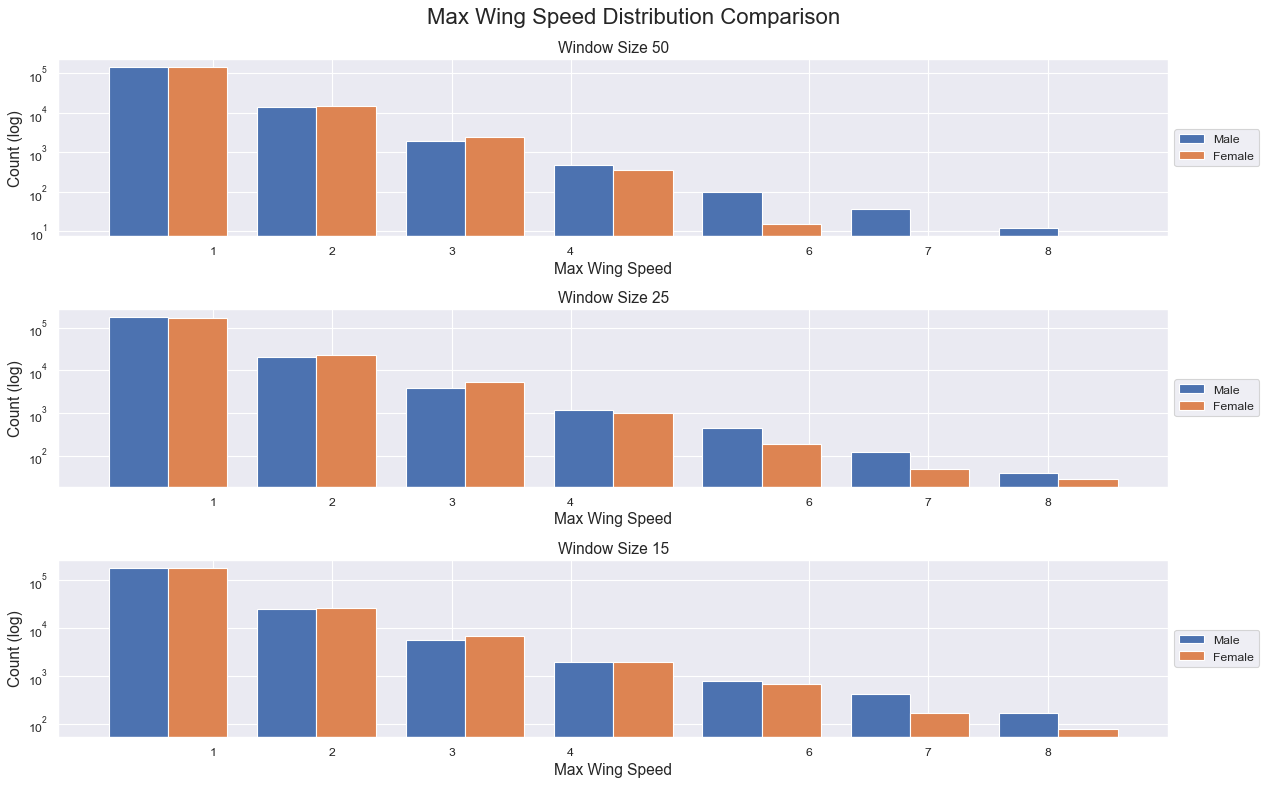

In [437]:
fig, ax = plt.subplots(3, 1, figsize=(16,10), dpi=80)
fig.suptitle("Max Wing Speed Distribution Comparison", fontsize=20)

_, bins, _ =ax[0].hist(trainWingSpeed[:,[0,3]], 7, label=["Male", "Female"], log=True)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title("Window Size 50", fontsize=14)
ax[0].set_xlabel("Max Wing Speed", fontsize=14)
ax[0].set_ylabel("Count (log)", fontsize=14)

xticks = np.zeros([np.size(bins)-1,])
for i in range(0, np.size(xticks)):
    xticks[i] = (bins[i] + bins[i+1]) / 2

ax[0].set_xticks(np.round(xticks))

#plt.subplot(3, 1, 2)
_, bins, _ =ax[1].hist(trainWingSpeed[:,[1,4]], bins, label=["Male", "Female"], log=True)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_title("Window Size 25", fontsize=14)
ax[1].set_xlabel("Max Wing Speed", fontsize=14)
ax[1].set_ylabel("Count (log)", fontsize=14)

#xticks = np.zeros([np.size(bins)-1,])
#for i in range(0, np.size(xticks)):
#    xticks[i] = (bins[i] + bins[i+1]) / 2

ax[1].set_xticks(np.round(xticks))

_, bins, _ =ax[2].hist(trainWingSpeed[:,[2,5]], bins, label=["Male", "Female"], log=True)
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].set_title("Window Size 15", fontsize=14)
ax[2].set_xlabel("Max Wing Speed", fontsize=14)
ax[2].set_ylabel("Count (log)", fontsize=14)

#xticks = np.zeros([np.size(bins)-1,])
#for i in range(0, np.size(xticks)):
#    xticks[i] = (bins[i] + bins[i+1]) / 2

ax[2].set_xticks(np.round(xticks))
fig.tight_layout()

Each plot here shows the distribution of max wing speed for both male and female flies. Here we can see how these distributions change across varying time windows.
Similar to the area and speed plots, the y-axis is the log counts and the x-axis is the binned speed.

More change is seen here when compared to the regular speed when varying the time window. Lower window size leads to higher kurtosis of the distribution. In window size 50, the high measures for wing speed are non-existent for females. This might imply more rapid changes.

## 2e. Bringing Together All Features

With the previously described features along with the area in part 1, we now have created enough features in order to build a model. Here you can select the window size that will apply to both speed and max wing speed in order to include those into the model.

In [304]:
import ipywidgets as widgets

windowSize = widgets.ToggleButtons(
    options=[15, 25, 50],
    description='Window Size:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Smaller Window', 'Larger Window', 'Largest Window'],
#     icons=['check'] * 3
)
windowSize

ToggleButtons(description='Window Size:', options=(15, 25, 50), tooltips=('Smaller Window', 'Larger Window', '…

In [305]:
if windowSize.value == 15:
    indSel = [2,5]
elif windowSize.value == 25:
    indSel = [1,4]
else:
    indSel = [0,3]

d = np.column_stack((trainX_area, trainSpeed[:,indSel], trainWS, trainDist, trainWingSpeed[:,indSel], trainX_m[:,53]))
columns = ["Area M", "Area F", "Speed M", "Speed F", "Wingspan M", "Wingspan F", "Distance", "Max Wing Speed M", "Max Wing Speed F", "label"]
trainDF = pd.DataFrame(data=d, columns=columns)

d = np.column_stack((testX_area, testSpeed[:,indSel], testWS, testDist, testWingSpeed[:,indSel], testX_m[:,53]))
columns = ["Area M", "Area F", "Speed M", "Speed F", "Wingspan M", "Wingspan F", "Distance", "Max Wing Speed M", "Max Wing Speed F", "label"]
testDF = pd.DataFrame(data=d, columns=columns)

d = np.column_stack((blindX_area, blindSpeed[:,indSel], blindWS, blindDist, blindWingSpeed[:,indSel]))
columns = ["Area M", "Area F", "Speed M", "Speed F", "Wingspan M", "Wingspan F", "Distance", "Max Wing Speed M", "Max Wing Speed F"]
blindDF = pd.DataFrame(data=d, columns=columns)

# 3. Visual Testing of Features
Using the plots from the tutorial, we can test for differences in features by comparing the labels visually.

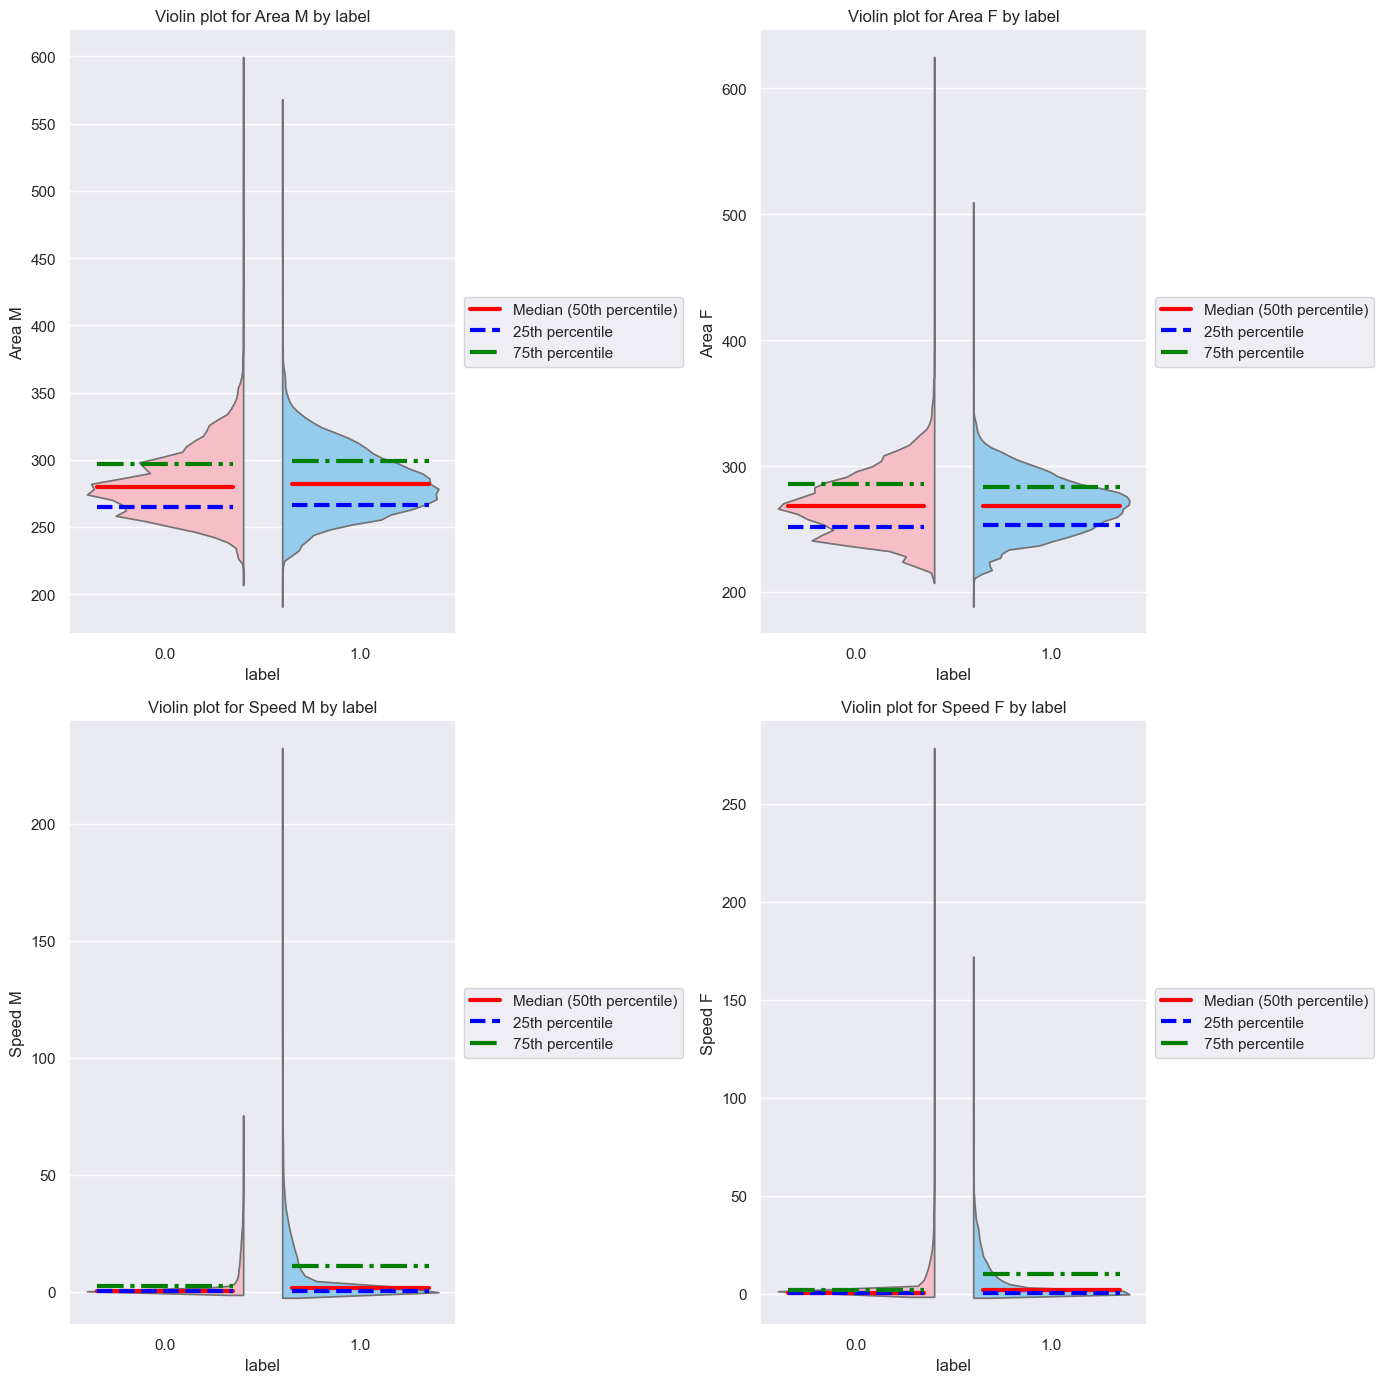

In [457]:
def plot_violin_with_statistics(df, col1, col2, col3, col4):
    # Assuming the label column is named 'label'
    label_column = 'label'

    # The selected feature columns
    feature_columns = [col1, col2, col3, col4]

    # Set up the 2x2 plotting area
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14) )

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # Define the colors for the violin plots
    palette = {0: "lightpink", 1: "lightskyblue"}

    # Plot each feature in the specified columns
    for i, feature in enumerate(feature_columns):
        sns.violinplot(x=label_column, y=feature, data=df, ax=axes[i], split=True, inner=None, hue=label_column, palette=palette, legend=False)

        # Overlay median, 25th percentile, and 75th percentile for both labels
        for label_value in df[label_column].unique():
            subset = df[df[label_column] == label_value][feature]
            median = subset.median()
            q25 = subset.quantile(0.25)
            q75 = subset.quantile(0.75)

            # Adjusting the plotting positions for better visibility
            axes[i].plot([label_value - 0.35, label_value + 0.35], [median, median], color='red', linestyle='-', linewidth=3)
            axes[i].plot([label_value - 0.35, label_value + 0.35], [q25, q25], color='blue', linestyle='--', linewidth=3)
            axes[i].plot([label_value - 0.35, label_value + 0.35], [q75, q75], color='green', linestyle='-.', linewidth=3)

        # Set the title and labels
        axes[i].set_title(f'Violin plot for {feature} by {label_column}')

        # Adding a custom legend for the percentiles to each subplot
        lines = [plt.Line2D([0], [0], color='red', linestyle='-', linewidth=3),
                 plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=3),
                 plt.Line2D([0], [0], color='green', linestyle='-.', linewidth=3)]
        labels = ['Median (50th percentile)', '25th percentile', '75th percentile']
        axes[i].legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Adjust layout for better readability
    fig.tight_layout()

plot_violin_with_statistics(trainDF,'Area M','Area F','Speed M','Speed F')

Each plot is the same. They each represent a feature that I have created. In each plot, the values of the measure are shown, separated by the label. The goal is to know whether there is a distinction in the feature across the label that would imply a predictive power.

On the x-axis you can see the separation by the label and on the y, the measure of the feature. The red line on each distribution is the median and the blue and green the 25th and 75th percentile, calculated via the IQR, respectively. 4 features are shown above.

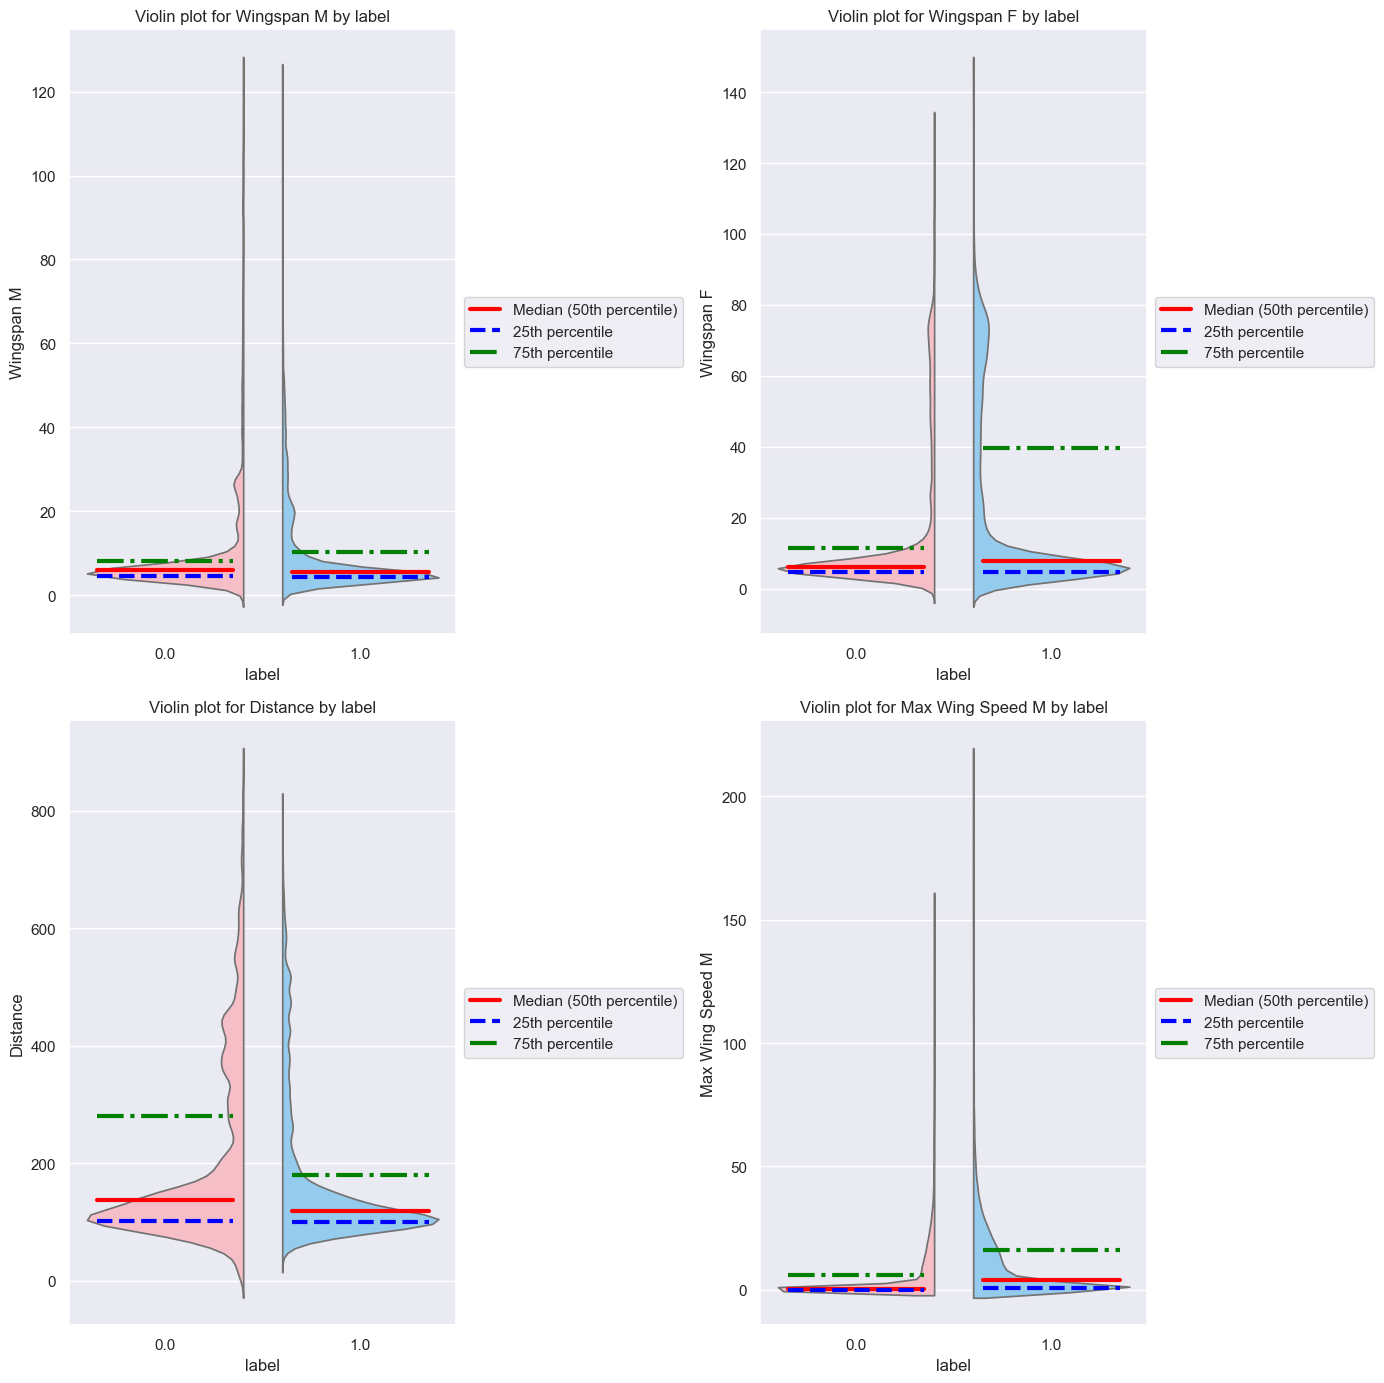

In [458]:
plot_violin_with_statistics(trainDF,"Wingspan M", "Wingspan F", "Distance", "Max Wing Speed M")

Each plot is the same. They each represent a feature that I have created. In each plot, the values of the measure are shown, separated by the label. The goal is to know whether there is a distinction in the feature across the label that would imply a predictive power.

On the x-axis you can see the separation by the label and on the y, the measure of the feature. The red line on each distribution is the median and the blue and green the 25th and 75th percentile, calculated via the IQR, respectively. 4 features are shown above.

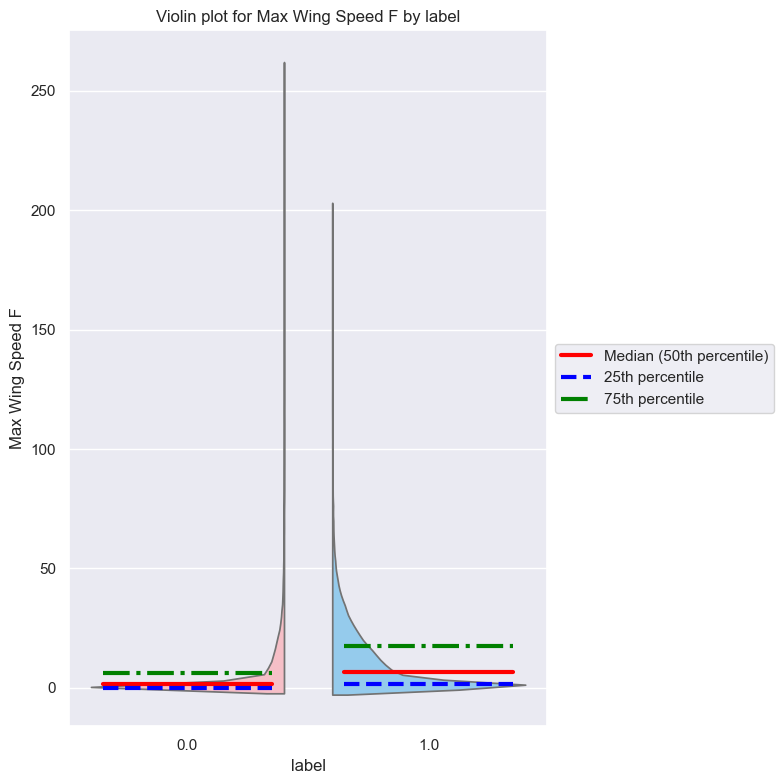

In [461]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.violinplot(x="label", y="Max Wing Speed F", data=trainDF, ax=ax, split=True, inner=None, hue="label", palette={0: "lightpink", 1: "lightskyblue"}, legend=False)

# Overlay median, 25th percentile, and 75th percentile for both labels
for label_value in trainDF["label"].unique():
    subset = trainDF[trainDF["label"] == label_value]["Max Wing Speed F"]
    median = subset.median()
    q25 = subset.quantile(0.25)
    q75 = subset.quantile(0.75)

    # Adjusting the plotting positions for better visibility
    ax.plot([label_value - 0.35, label_value + 0.35], [median, median], color='red', linestyle='-', linewidth=3)
    ax.plot([label_value - 0.35, label_value + 0.35], [q25, q25], color='blue', linestyle='--', linewidth=3)
    ax.plot([label_value - 0.35, label_value + 0.35], [q75, q75], color='green', linestyle='-.', linewidth=3)

# Set the title and labels
ax.set_title(f'Violin plot for {"Max Wing Speed F"} by {"label"}')

# Adding a custom legend for the percentiles to each subplot
lines = [plt.Line2D([0], [0], color='red', linestyle='-', linewidth=3),
            plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=3),
            plt.Line2D([0], [0], color='green', linestyle='-.', linewidth=3)]
labels = ['Median (50th percentile)', '25th percentile', '75th percentile']
ax.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout for better readability
fig.tight_layout()

Just like the previous 2 collection of plots, but on its own since I have 9 total. 

They each represent a feature that I have created. In the plot, the values of the measure are shown, separated by the label. The goal is to know whether there is a distinction in the feature across the label that would imply a predictive power.

On the x-axis you can see the separation by the label and on the y, the measure of the feature. The red line on each distribution is the median and the blue and green the 25th and 75th percentile, calculated via the IQR, respectively.

## 3b. Which Features are better predictors?
I believe that distance, max wing speed, wing span F and speed will be good predictors for the labels. As the plots show, they demonstrate quantitative differences in their distributions across the labels, thus implying a predictive power in the training set. If the testing and blind data is similar to the training data, then this power is likely to be useful there too.

# 4. Train and Evaluate Models on Training Set with 80/20 Split
## 4a. Random Forest

In [309]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def build_and_train_rf(df, n_estimators=100, max_depth=None, test_size=0.2, random_state=None):
    # Separate features and labels
    X = df.iloc[:, :-1]  # First 25 columns are features
    y = df.iloc[:, -1]   # Last column is the label

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

    return rf_model, scaler 

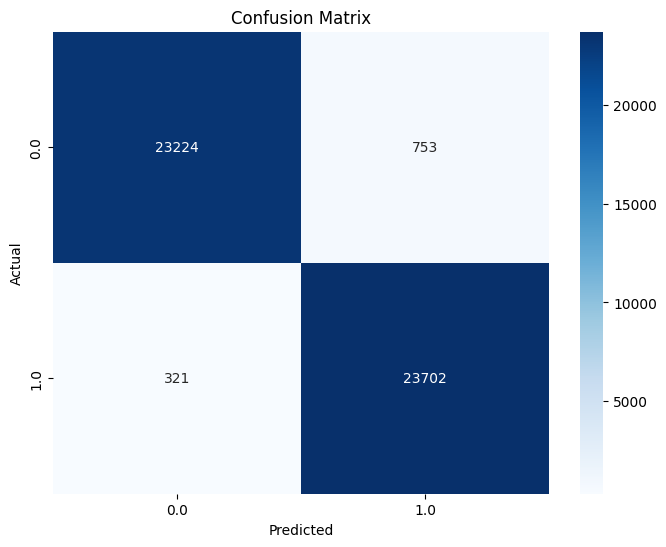

Accuracy: 0.9776
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     23977
         1.0       0.97      0.99      0.98     24023

    accuracy                           0.98     48000
   macro avg       0.98      0.98      0.98     48000
weighted avg       0.98      0.98      0.98     48000



In [ ]:
rf_model, scaler = build_and_train_rf(trainDF, n_estimators=100, max_depth=None, test_size=0.2, random_state=None)

confusion matrix illustrating the results of the random forest model built from just the training data. 

On the x-axis you have the prediction and on the y-axis the actual. The numbers inside the box indicate the raw results of the model, and what it predicted and what was the actual label. The color is an easier way to analyze, without having to understand the magnitude of the numbers, the overall accuracy of the model.

The goal is to have it so that when you predict the label 0, for it to be actually 0 and the same for the label 1. As a consequence, you want to see strong colors/numbers on the negative diagonal (just like in the example above).

## 4b. Neural Network

In [315]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network  import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

def build_and_train_nn_adam(train_df, test_size, alpha, activation='tanh', hiddenLayerSizes=(10,10,10),random_state=None):
    # Separate features and labels
    X = train_df.iloc[:, :-1]  # All columns except the last are features
    y = train_df.iloc[:, -1]   # Last column is the label

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Neural Network model
    #clf = MLPClassifier(solver='adam', alpha=regTerm, activation=activation, hidden_layer_sizes=hiddenLayerSizes, max_iter=20, random_state=1, early_stopping=True, validation_fraction=.1)
    clf = MLPClassifier(activation=activation, alpha=alpha, hidden_layer_sizes=hiddenLayerSizes, random_state=random_state)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

    return rf_model, scaler

f:\NatBehFinalProj\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


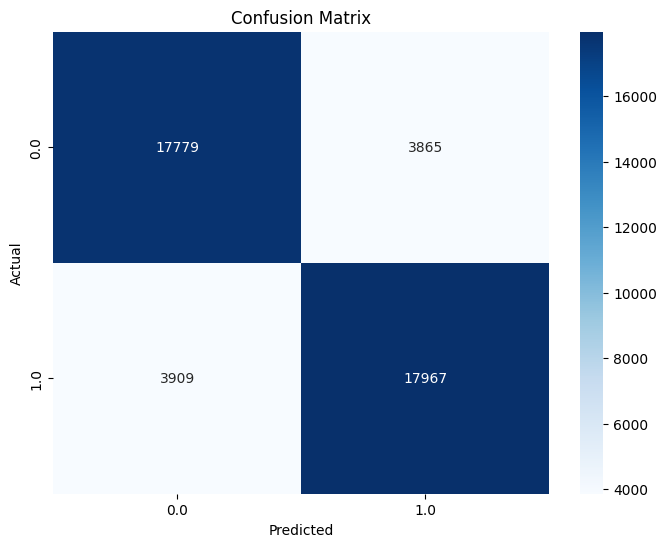

Accuracy: 0.8214
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.82      0.82     21644
         1.0       0.82      0.82      0.82     21876

    accuracy                           0.82     43520
   macro avg       0.82      0.82      0.82     43520
weighted avg       0.82      0.82      0.82     43520



In [316]:
rf_model, scaler = build_and_train_nn_adam(trainDF.dropna(), .2, 1e-3, activation='tanh', hiddenLayerSizes=(10,10,10))

Plotted above is the confusion matrix illustrating the results of a neural network built from just the training data. 

On the x-axis you have the prediction and on the y-axis the actual. The numbers inside the box indicate the raw results of the model, and what it predicted and what was the actual label. The color is an easier way to analyze, without having to understand the magnitude of the numbers, the overall accuracy of the model.

# 5. Train and Evaluate Models On Training Set and Test Data
## 5a. Random Forest

In [308]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def build_and_train_rf_with_test(train_df, test_df, n_estimators=100, max_depth=None, random_state=None):
    # Separate features and labels for training data
    X_train = train_df.iloc[:, :-1]  # All columns except the last are features
    y_train = train_df.iloc[:, -1]   # The last column is the label

    # Separate features and labels for testing data
    X_test = test_df.iloc[:, :-1]
    y_test = test_df.iloc[:, -1]

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

    return rf_model, scaler  # Return both the model and the scaler

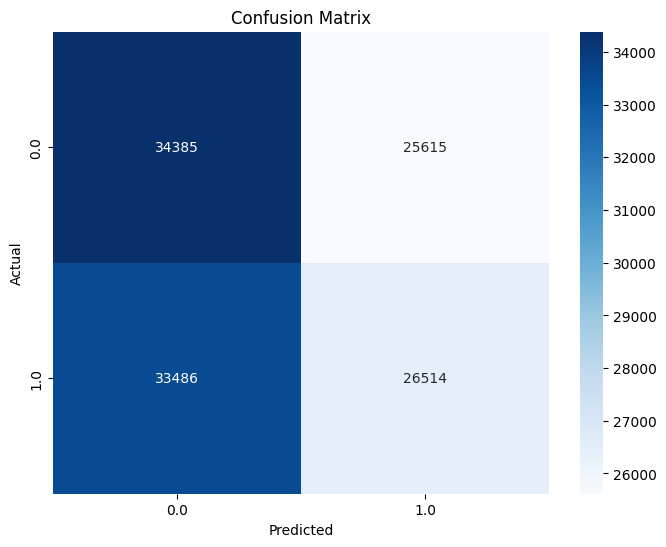

Accuracy: 0.5075
Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.57      0.54     60000
         1.0       0.51      0.44      0.47     60000

    accuracy                           0.51    120000
   macro avg       0.51      0.51      0.51    120000
weighted avg       0.51      0.51      0.51    120000



In [ ]:
rf_model, scaler = build_and_train_rf_with_test(trainDF, testDF, n_estimators=150, max_depth=None)

Plotted above is the confusion matrix illustrating the results of the random forest model built with the training data and tested on the test data

On the x-axis you have the prediction and on the y-axis the actual. The numbers inside the box indicate the raw results of the model, and what it predicted and what was the actual label. The color is an easier way to analyze, without having to understand the magnitude of the numbers, the overall accuracy of the model.

## 5b. Neural Network

In [ ]:
def build_and_train_nn_adam_with_test(train_df, test_df, alpha, activation='tanh', hiddenLayerSizes=(10,10,10),random_state=None):
    # Separate features and labels for training data
    X_train = train_df.iloc[:, :-1]  # All columns except the last are features
    y_train = train_df.iloc[:, -1]   # The last column is the label

    # Separate features and labels for testing data
    X_test = test_df.iloc[:, :-1]
    y_test = test_df.iloc[:, -1]

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Neural Network model
    #clf = MLPClassifier(solver='adam', alpha=regTerm, activation=activation, hidden_layer_sizes=hiddenLayerSizes, max_iter=20, random_state=1, early_stopping=True, validation_fraction=.1)
    clf = MLPClassifier(activation=activation, alpha=alpha, hidden_layer_sizes=hiddenLayerSizes, random_state=random_state)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

    return rf_model, scaler

f:\NatBehFinalProj\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


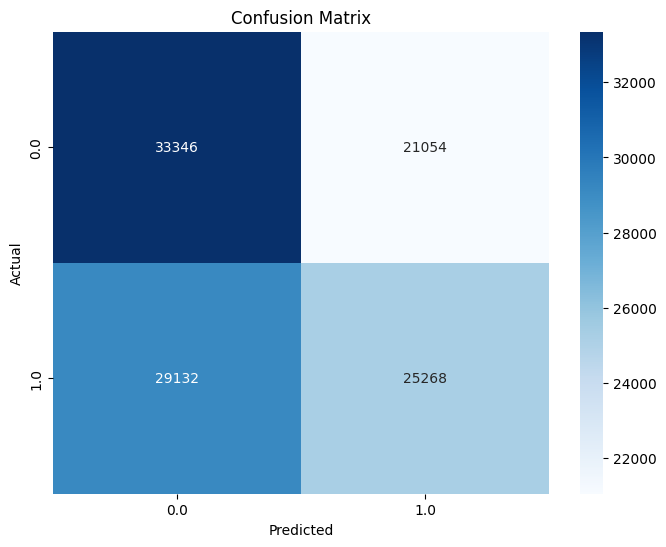

Accuracy: 0.5387
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.61      0.57     54400
         1.0       0.55      0.46      0.50     54400

    accuracy                           0.54    108800
   macro avg       0.54      0.54      0.54    108800
weighted avg       0.54      0.54      0.54    108800



In [314]:
rf_model, scaler = build_and_train_nn_adam_with_test(trainDF.dropna(), testDF.dropna(), 1e-3, activation='tanh', hiddenLayerSizes=(10,10,10))

Plotted above is the confusion matrix illustrating the results of a neural network built with the training data and tested on the test data

On the x-axis you have the prediction and on the y-axis the actual. The numbers inside the box indicate the raw results of the model, and what it predicted and what was the actual label. The color is an easier way to analyze, without having to understand the magnitude of the numbers, the overall accuracy of the model.

## 5c. Comparing 4 and 5 Results
Splitting the training set gave better results than training and testing on different sets. This could be due to differences in the data between the two sets, i.e. they are not homogenous enough. The flies could be at different stages in their courtship or time of day. It depends on what the label means, I do not know.

In class I had time to run hyperparameter optimization, but I did not do that here. I could be that I could grab a few more points of accuracy from both the random forest and neural network with this. This is another exercise left to the reader.

# 6. Enhanced Preprocessing
## 6a. Preprocessing Step

In [ ]:
#guau, get those chunks into single rows
trainPP = trainDF.groupby(np.arange(len(trainDF))//150).mean()
trainPP['label'] = trainY['labels'].values

testPP = testDF.groupby(np.arange(len(testDF))//150).mean()
testPP['label'] = testY['labels'].values

blindPP = blindDF.groupby(np.arange(len(blindDF))//150).mean()

## 6b. Random Forest

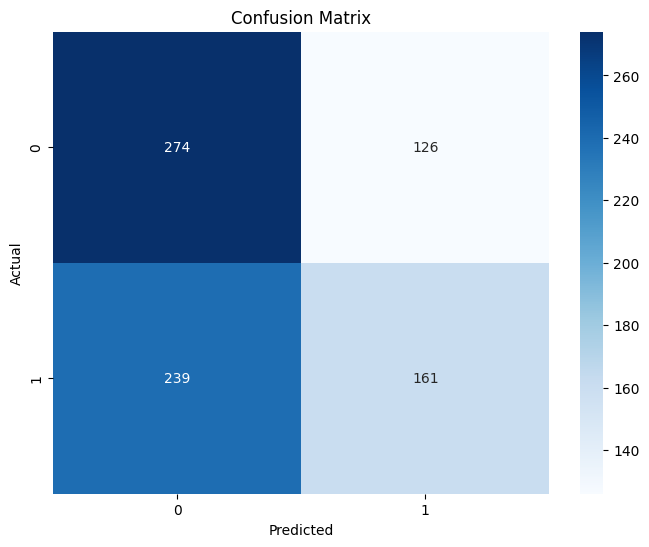

Accuracy: 0.5437
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.69      0.60       400
           1       0.56      0.40      0.47       400

    accuracy                           0.54       800
   macro avg       0.55      0.54      0.53       800
weighted avg       0.55      0.54      0.53       800



In [330]:
rf_model, scaler = build_and_train_rf_with_test(trainPP, testPP, n_estimators=150, max_depth=None)

Plotted above is the confusion matrix illustrating the results of a random forest model built with the training data and tested on the test data, but with an additional pre-processing step.

On the x-axis you have the prediction and on the y-axis the actual. The numbers inside the box indicate the raw results of the model, and what it predicted and what was the actual label. The color is an easier way to analyze, without having to understand the magnitude of the numbers, the overall accuracy of the model.

## 6c. Neural Network

f:\NatBehFinalProj\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


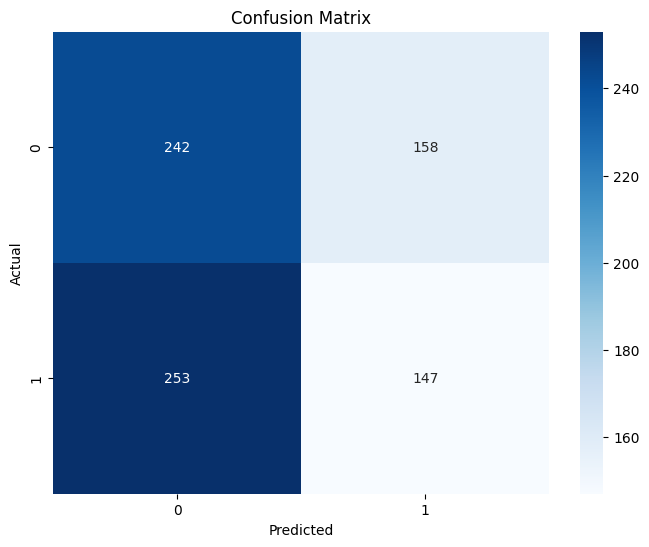

Accuracy: 0.4863
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.60      0.54       400
           1       0.48      0.37      0.42       400

    accuracy                           0.49       800
   macro avg       0.49      0.49      0.48       800
weighted avg       0.49      0.49      0.48       800



In [331]:
rf_model, scaler = build_and_train_nn_adam_with_test(trainPP.dropna(), testPP.dropna(), 1e-3, activation='tanh', hiddenLayerSizes=(10,10,10))

Plotted above is the confusion matrix illustrating the results of a neural network built with the training data and tested on the test data, but with an additional pre-processing step.

On the x-axis you have the prediction and on the y-axis the actual. The numbers inside the box indicate the raw results of the model, and what it predicted and what was the actual label. The color is an easier way to analyze, without having to understand the magnitude of the numbers, the overall accuracy of the model.

# 7. Blind Test Prediction with Random Forest

In [462]:
def build_and_train_rf_blind(train_df, test_df, n_estimators=100, max_depth=None, random_state=None):
    # Separate features and labels for training data
    X_train = train_df.iloc[:, :-1]  # All columns except the last are features
    y_train = train_df.iloc[:, -1]   # The last column is the label

    # Separate features and labels for testing data
    X_test = test_df

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    return y_pred  # Return both the model and the scaler

y_pred = build_and_train_rf_blind(pd.concat([trainPP, testPP], ignore_index=True), blindPP, n_estimators=150, max_depth=None)

blindPredDF = pd.DataFrame(data=y_pred, columns=["labels"])
blindPredDF.to_csv('blind_test_prediction.csv', index=True) 